In [1]:
import pandas as pd
import numpy as np
import ribo_processing as rp
import matplotlib.pyplot as plt
import pysam, numpy, sys
%matplotlib inline

In [2]:
cd ~/labwork/riboprofiling/glucose_noab/

/home/tjustin/labwork/riboprofiling/glucose_noab


In [3]:
gene_df, genome_seq_df = rp.geneFrame('../NC_000913.2.gb')

/usr/local/lib/python2.7/dist-packages/biopython-1.65-py2.7-linux-x86_64.egg/Bio/Seq.py:342: BiopythonDeprecationWarning: This method is obsolete; please use str(my_seq) instead of my_seq.tostring().
  BiopythonDeprecationWarning)


In [4]:
!sh ./ec_riboprofiling_processing.sh antibioticinmedia_S1_L001_R1_001.fastq

Now processing antibioticinmedia_S1_L001_R1_001.fastq
This is cutadapt 1.8 with Python 2.7.6
Command line parameters: -a AGATCGGAAGAGCACACGTCT -m 15 antibioticinmedia_S1_L001_R1_001.fastq
Trimming 1 adapter(s) with at most 10.0% errors in single-end mode ...
Finished in 57.13 s (6 us/read; 9.63 M reads/minute).

=== Summary ===

Total reads processed:               9,173,033
Reads with adapters:                 9,084,658 (99.0%)
Reads that were too long:              421,815 (4.6%)
Reads written (passing filters):     8,751,218 (95.4%)

Total basepairs processed:   568,728,046 bp
Total written (filtered):    245,302,422 bp (43.1%)

=== Adapter 1 ===

Sequence: AGATCGGAAGAGCACACGTCT; Type: regular 3'; Length: 21; Trimmed: 9084658 times.

No. of allowed errors:
0-9 bp: 0; 10-19 bp: 1; 20-21 bp: 2

Bases preceding removed adapters:
  A: 10.4%
  C: 30.0%
  G: 47.6%
  T: 11.6%
  none/other: 0.4%

Overview of removed sequences
length	count	expect	max.err	error counts
3	9855	143328.6	0	9855
4

# Checking for source of tRNA contamination

In [5]:
import pysam, numpy, sys

In [6]:
def get_references(samfile):
    ref_names = []
    read_iter = samfile.fetch()
        
    for read in read_iter:
        if read.is_unmapped==False:
            reference = samfile.getrname(read.reference_id)
            ref_names.append(reference)
            
    return ref_names

In [10]:
tRNA_samfile = pysam.Samfile('antibioticinmedia_S1_L001_R1_001_ec_trna_btw_aligned.sam', 'r')
tRNAs = get_references(tRNA_samfile)
unique,counts = np.unique(np.array(tRNAs), return_counts=True)

([<matplotlib.axis.XTick at 0x7f385c55e210>,
 <a list of 86 Text xticklabel objects>)

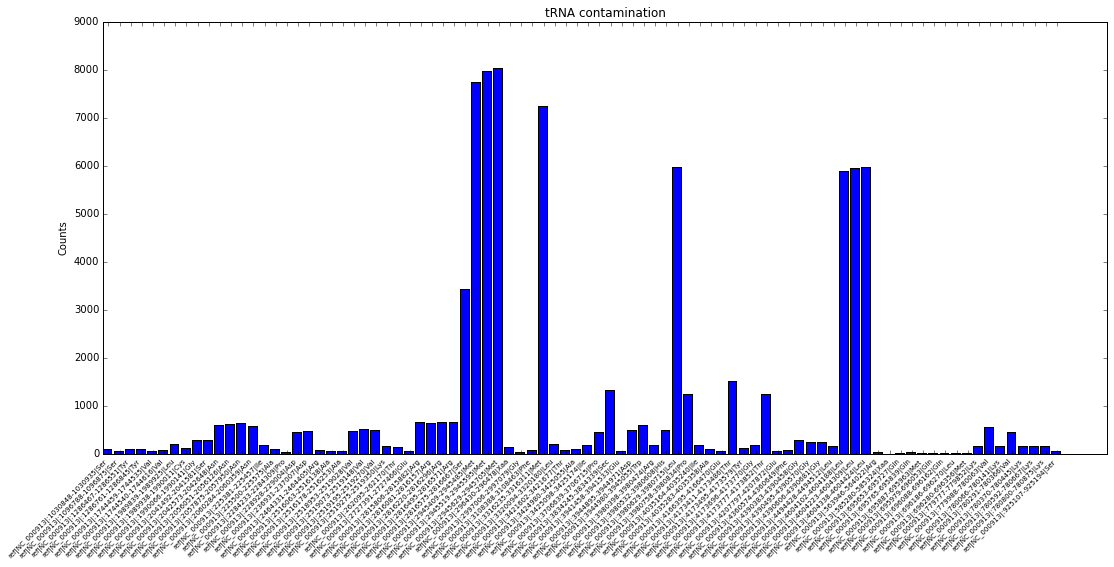

In [25]:
plt.figure(figsize=(18,10))

h = plt.bar(xrange(len(unique)), counts, label=unique)
plt.subplots_adjust(bottom=0.3)

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.ylabel('Counts')
plt.title('tRNA contamination')
plt.xticks(xticks_pos, unique,  ha='right', rotation=45, size=7)

# Checking for source of rRNA contamination

In [26]:
rRNA_samfile = pysam.Samfile('antibioticinmedia_S1_L001_R1_001_ec_rRNA_ext_btw_aligned.sam', 'r')
rRNAs = get_references(rRNA_samfile)
unique,counts = np.unique(np.array(rRNAs), return_counts=True)

([<matplotlib.axis.XTick at 0x7f385c000e50>,
 <a list of 22 Text xticklabel objects>)

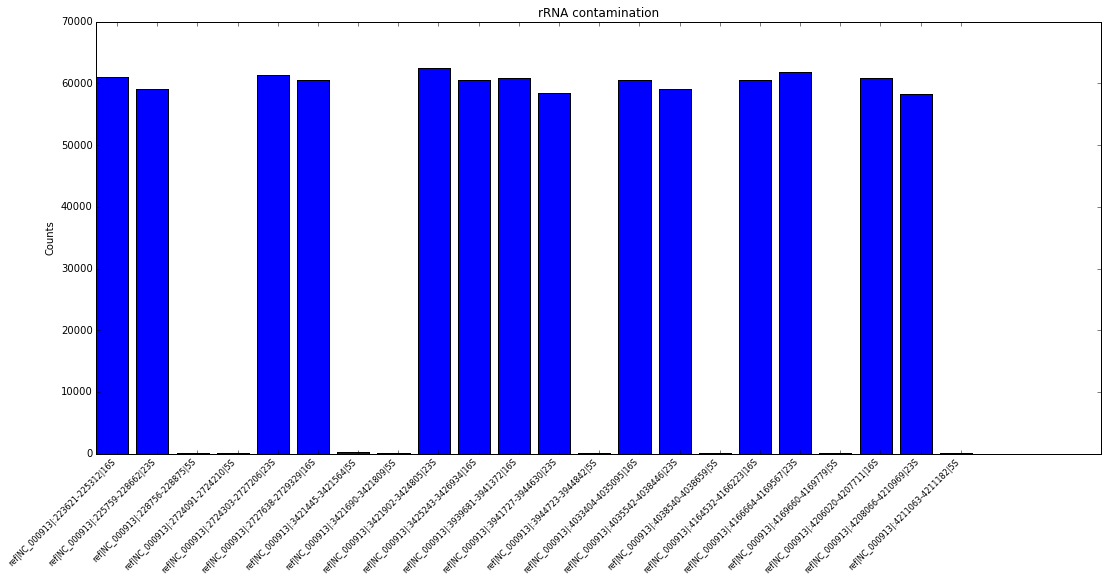

In [27]:
plt.figure(1, figsize=(18,10))

h = plt.bar(xrange(len(unique)), counts, label=unique)
plt.subplots_adjust(bottom=0.3)

xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.ylabel('Counts')
plt.title('rRNA contamination')
plt.xticks(xticks_pos, unique,  ha='right', rotation=45, size=8)

# Ribosome profiling pipeline

In [4]:
complexes = pd.read_csv('../ec_complexes.csv',names=['complex','gene_name','stoichiometry','operon_type'])
complex_list = np.unique(complexes.complex.values)

## Center weighting

In [5]:
cw_raw = rp.center_weighting_from_sam('antibioticinmedia_S1_L001_R1_001_non_RNA_aligned.sam')
#cw_raw.to_csv('antibioticin_center_weighted.csv')
#cw_raw = pd.read_csv('antibioticin_center_weighted.csv', index_col=0)

## Dropoff correction

The calculated function parameters are: 
A=0.882907
K=0.015028
C=0.366631
Sum of residuals squared=0.068357


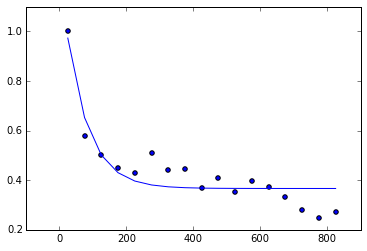

In [6]:
cw_dropoff = rp.exp_dropoff_correction(gene_df, cw_raw)

In [17]:
cw_dropoff.to_csv('antibioticin_cw_dropoff.csv')

In [7]:
cw_final = rp.pause_site_correction(gene_df, cw_dropoff, rp.countReads(cw_dropoff))

In [18]:
cw_final.to_csv('antibioticin_cw_final.csv')

## Comparing pre and post corrections

In [9]:
start_meta_raw, stop_meta_raw = rp.meta_gene(gene_df, cw_raw)
start_meta_dropoff, stop_meta_dropoff = rp.meta_gene(gene_df, cw_dropoff)
start_meta_final, stop_meta_final = rp.meta_gene(gene_df, cw_final)

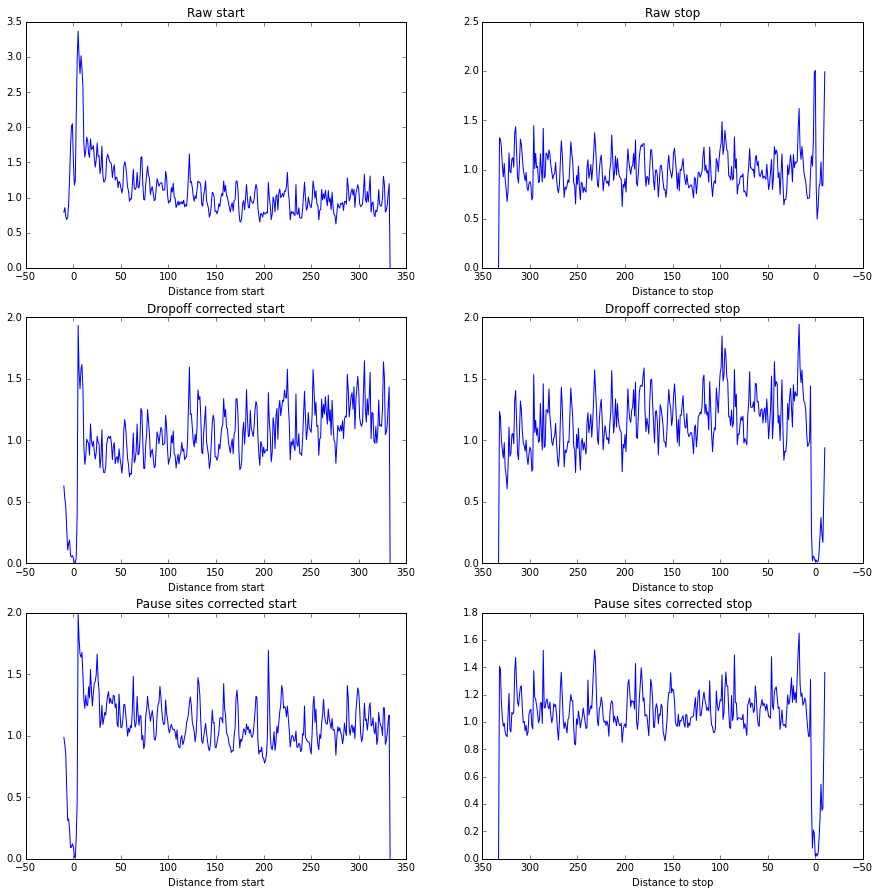

In [10]:
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.plot(start_meta_raw.mean(axis=0).index, start_meta_raw.mean(axis=0))
plt.xlabel('Distance from start')
plt.title('Raw start')

plt.subplot(323)
plt.plot(start_meta_dropoff.mean(axis=0).index, start_meta_dropoff.mean(axis=0))
plt.xlabel('Distance from start')
plt.title('Dropoff corrected start')

plt.subplot(325)
plt.plot(start_meta_final.mean(axis=0).index, start_meta_final.mean(axis=0))
plt.xlabel('Distance from start')
plt.title('Pause sites corrected start')

plt.subplot(322)
plt.plot(stop_meta_raw.mean(axis=0).index, stop_meta_raw.mean(axis=0))
plt.xlabel('Distance to stop')
plt.title('Raw stop')
ax=plt.gca()
ax.invert_xaxis()

plt.subplot(324)
plt.plot(stop_meta_dropoff.mean(axis=0).index, stop_meta_dropoff.mean(axis=0))
plt.xlabel('Distance to stop')
plt.title('Dropoff corrected stop')
ax=plt.gca()
ax.invert_xaxis()

plt.subplot(326)
plt.plot(stop_meta_final.mean(axis=0).index, stop_meta_final.mean(axis=0))
plt.xlabel('Distance to stop')
plt.title('Pause sites corrected stop')
ax=plt.gca()
ax.invert_xaxis()

#Complexes 

In [11]:
rpm = rp.RPM_normed_gene_expression(gene_df,cw_raw,rp.countReads(cw_raw))
#rpm.to_csv('antibioticin_rpm.csv')

In [12]:
abs_rate = rp.absolute_synthesis_rate(gene_df,rpm,238)

In [13]:
complexes_antibioticin = complexes.join(abs_rate)

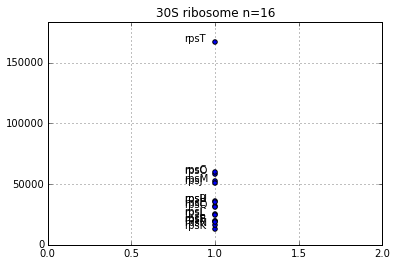

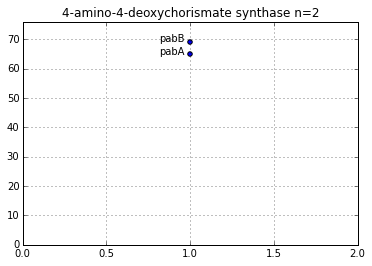

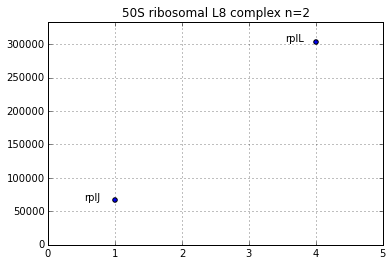

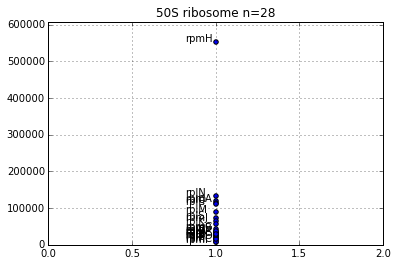

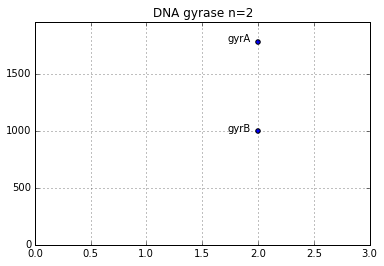

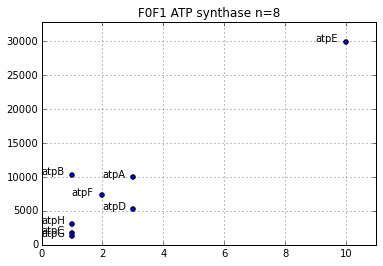

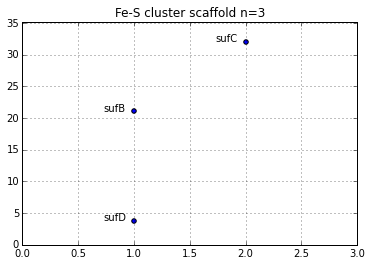

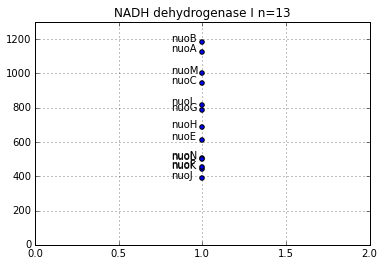

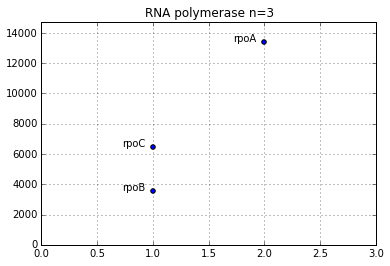

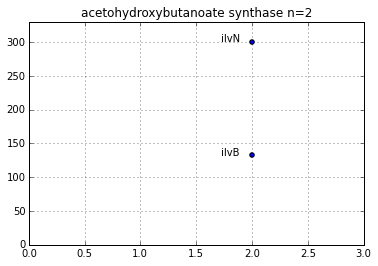

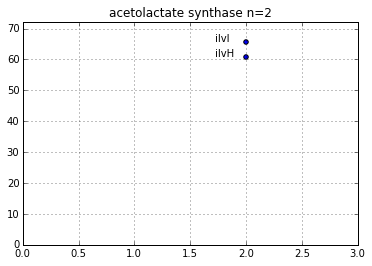

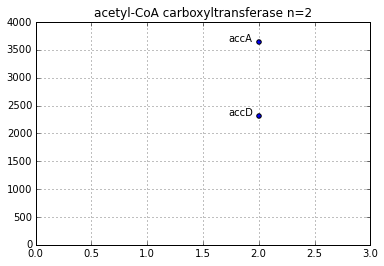

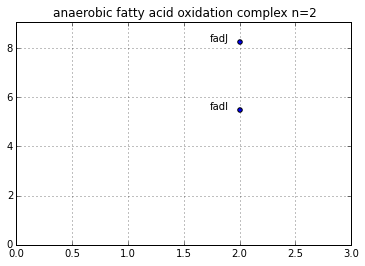

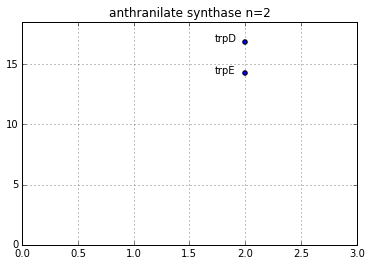

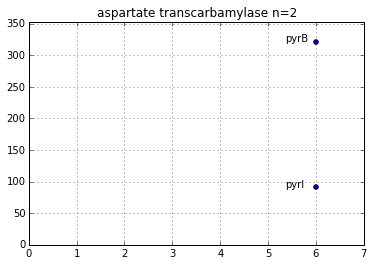

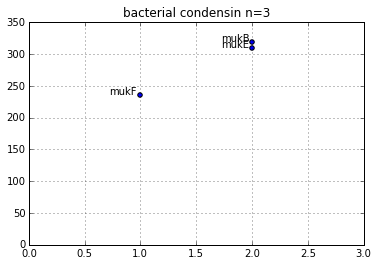

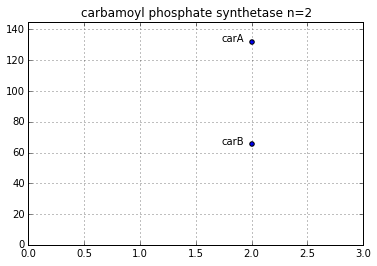

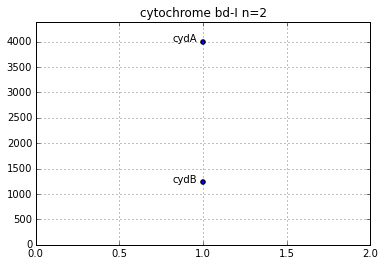

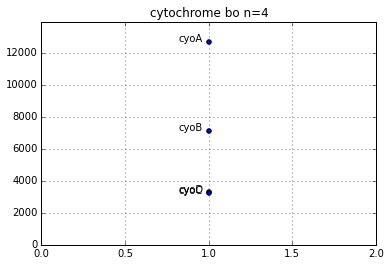

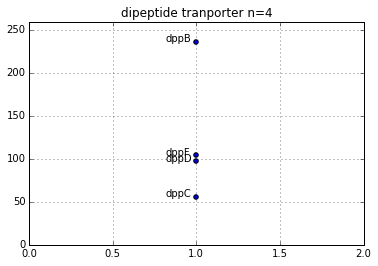

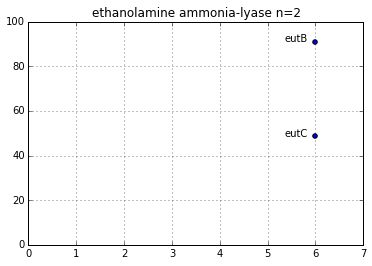

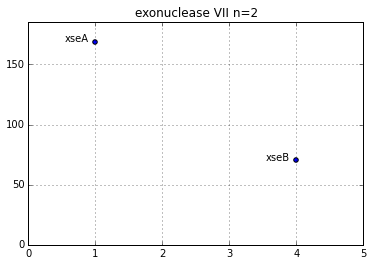

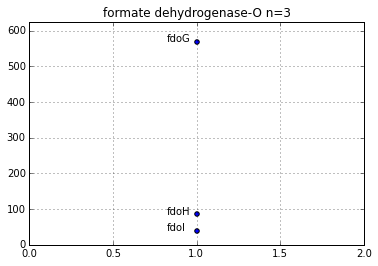

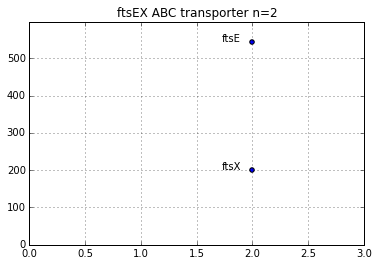

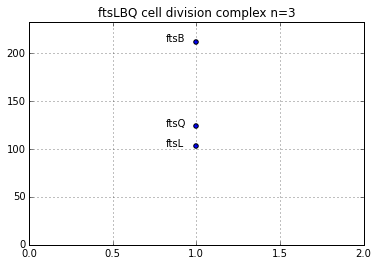

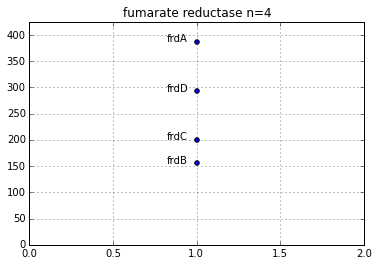

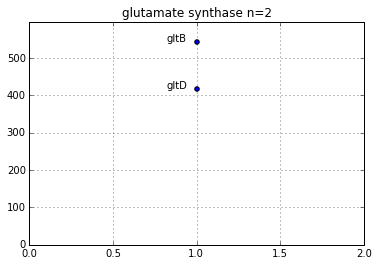

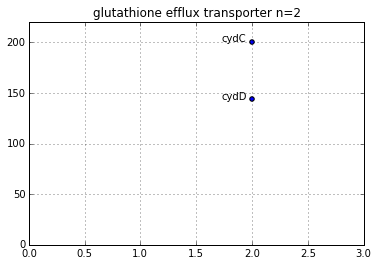

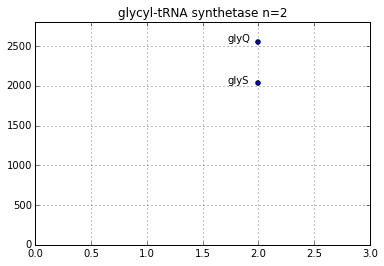

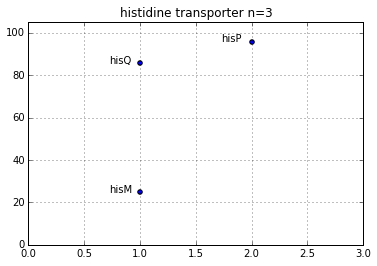

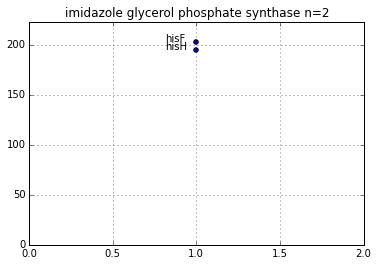

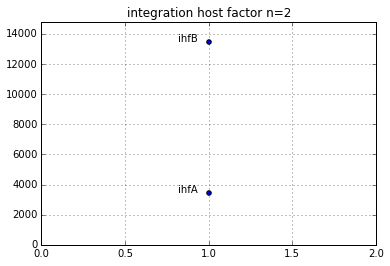

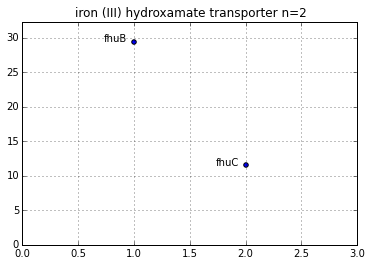

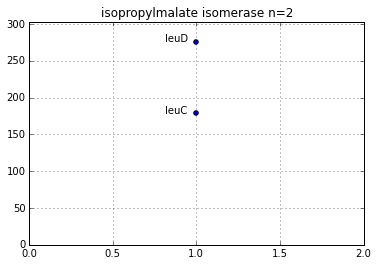

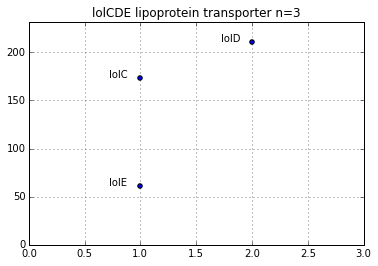

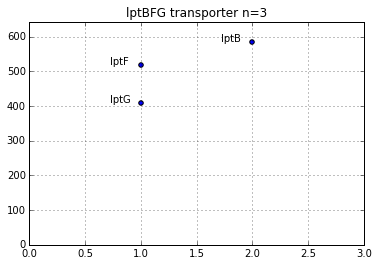

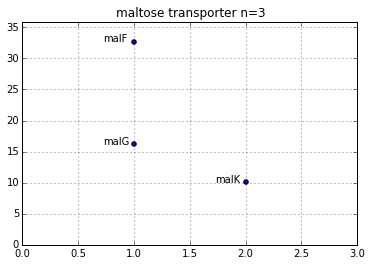

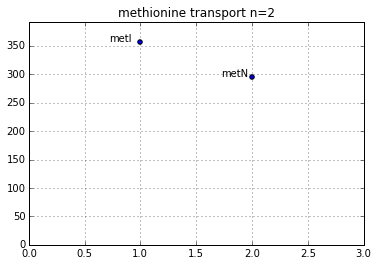

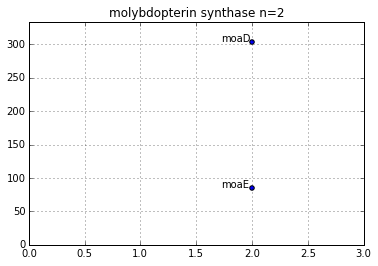

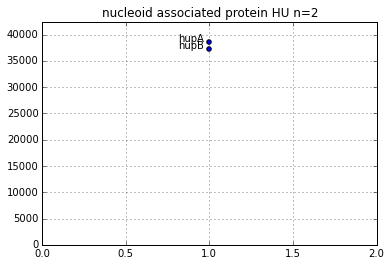

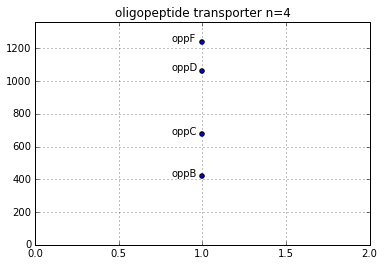

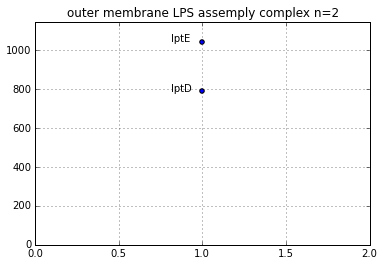

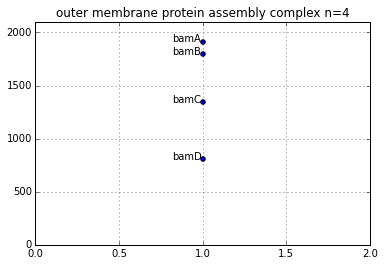

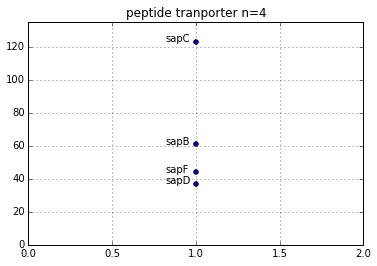

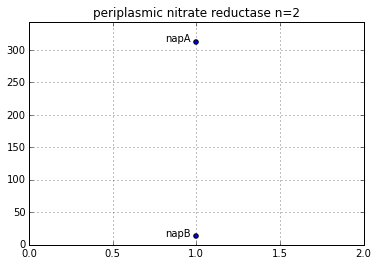

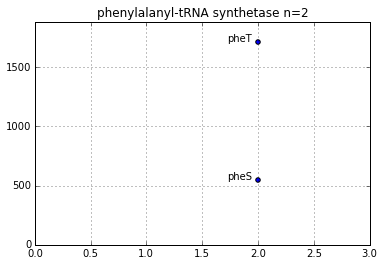

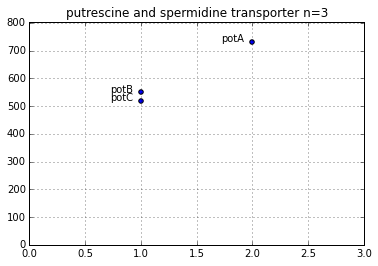

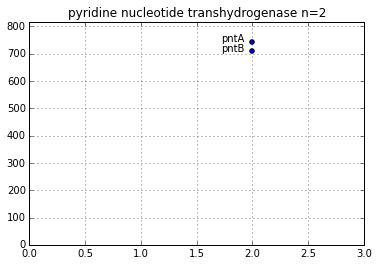

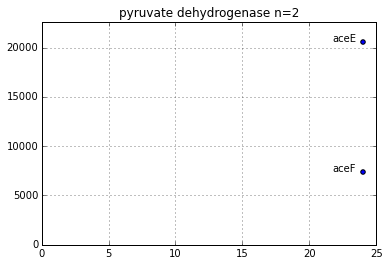

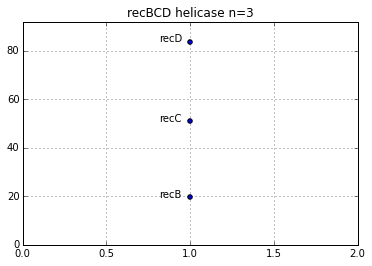

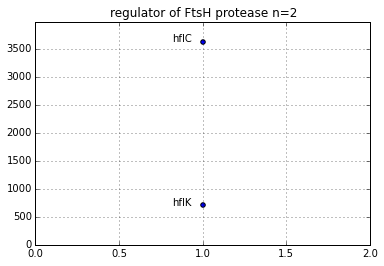

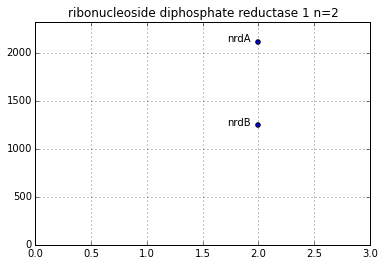

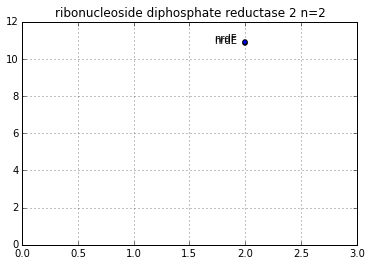

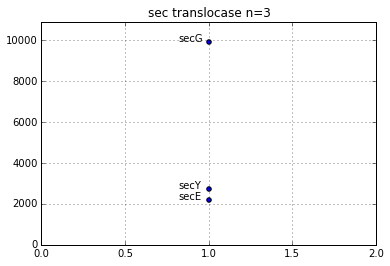

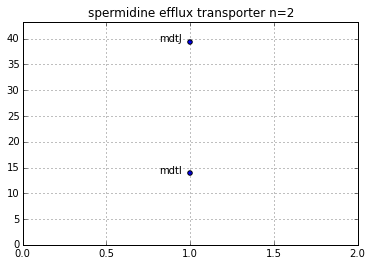

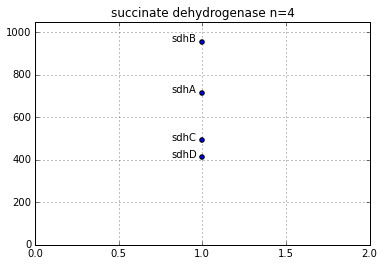

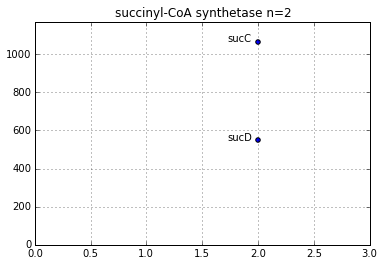

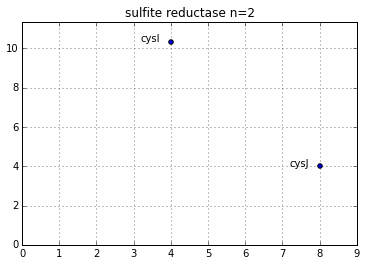

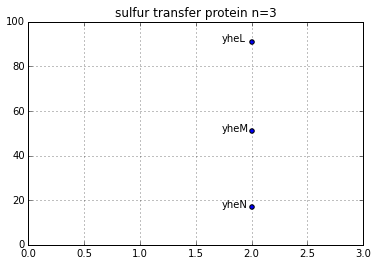

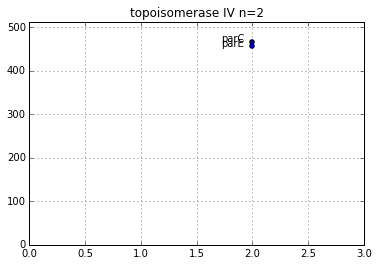

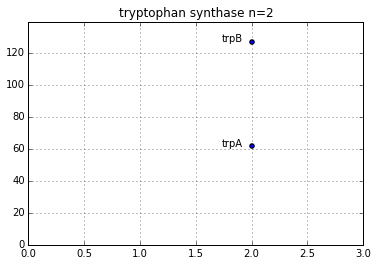

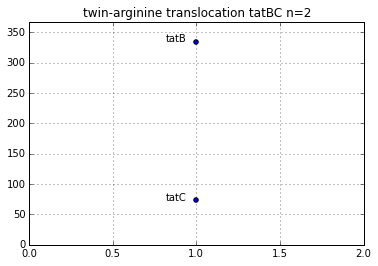

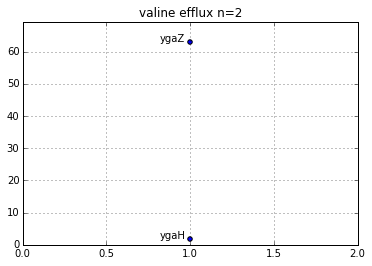

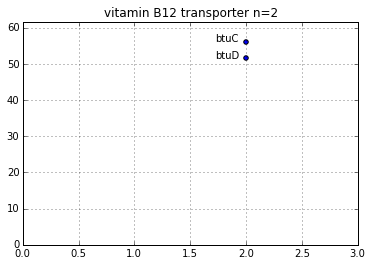

In [14]:
for complex in complex_list:
    vals = complexes_antibioticin.ix[complexes_antibioticin['complex']==complex,['stoichiometry', 'absolute_rate','gene_name']]
    vals = vals.sort()
    
    plt.scatter(vals.stoichiometry, vals.absolute_rate)
    for index, row in vals.iterrows():
        plt.annotate(row['gene_name'], xy=(row['stoichiometry'],row['absolute_rate']),xytext = (-30, 0),textcoords = 'offset points')
    plt.title('%s n=%i'%(complex,len(vals)))
    plt.ylim(0,vals.absolute_rate.max()*1.1)
    #yscale('log')
    plt.xlim(0, vals.stoichiometry.max()+1)
    #plt.xlim(vals.stoichiometry.min()-1, vals.stoichiometry.max()+1)
    #plt.ylim(vals.stoichiometry.min()-1, vals.stoichiometry.max()+1)
    plt.grid()
    plt.show()